### Proyecto de Análisis Estadístico. Módulo 2
### Analysis Statistics Project

Importando las librerías que vamos a usar.

Importing the usefull librarys 

In [147]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

sns.set()

In [4]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
          corr['x'], corr['y'],
          color=corr['value'], color_range=[-1, 1],
          palette=sns.diverging_palette(20, 220, n=256),
          size=corr['value'].abs(), size_range=[0,1],
          marker=marker,
          x_order=data.columns,
          y_order=data.columns[::-1],
          size_scale=size_scale
      )

## Revisando los datos

In [5]:
data = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

In [6]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.shape

(1460, 81)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


# Datos nulos nans.
Revisando que sucede con los datos nulos. Se analiza cada caso para rellenar la información con los valores más convenientes por columna.

Checking what happens with the null data. Each case is analyzed to fill in the information with the most convenient values per column. 

In [11]:
#data['CentralAir'] = data['CentralAir'].replace({"N":0 , "Y":1})
null_cols = data.isnull().sum()
null_cols = null_cols[null_cols != 0]
print('Columns with nans\n',len(null_cols))
null_cols.sort_values()

Columns with nans
 19


Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [12]:
data_numeric = data._get_numeric_data()
data_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Se revisa que registros se tienen en la columna PoolArea cuando PoolQC es nulo, al ser la media igual a 0 con una desviación estandar se concluye que corresponden a casas que no tienen alberca. Es lógico que no se puede asignar una calidad a la alberca si no existe. 


In [13]:
mean_ = data[data['PoolQC'].isnull() == True ]['PoolArea'].mean()
std_ = data[data['PoolQC'].isnull() == True ]['PoolArea'].std()
#data[['displ', 'cylinders']] = data[['displ', 'cylinders']].fillna(0)
data.loc[(data['PoolQC'].isnull() == True) & (data['PoolArea'] == 0),'PoolQC']  = 'NA'
print(f'El promedio del área de alberca para los datos que tienen nulos en la calidad de alberca es {mean_}')
print(f'La desviación estandar de los datos del área de alberca para los datos que tienen nulos en la calidad de alberca es {std_}')
data['PoolQC'].unique()

El promedio del área de alberca para los datos que tienen nulos en la calidad de alberca es 0.0
La desviación estandar de los datos del área de alberca para los datos que tienen nulos en la calidad de alberca es 0.0


array(['NA', 'Ex', 'Fa', 'Gd'], dtype=object)

Para el caso de la cerca se registraran los valores nulos como casas sin cerca. Pensando un poco en USa son muy comunes las casa que no cuentan con cerca. 

For the fence case, there isn't  'no fence' data.  It's a common practices do not have fence in the USA houses. Thats why the nulls are replaced by IN, accordance with the key in the data description file.

In [14]:
print(data['Fence'].value_counts())
data.loc[(data['Fence'].isnull() == True), 'Fence'] = 'NA'

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


Nos damos cuenta que la columna de Utilities todos son tienen todos los servicios públicos excepto uno, por lo que se mete a la lista de eliminación de columnas ya que o aporta información para diferenciar. 

In [15]:
columns_toDrop = ['Utilites']
data[(data['MiscFeature'].isnull() == False)]['Utilities'].value_counts()
data['Utilities'].value_counts()
data[data['Utilities']== 'NoSeWa']
#

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
944,945,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,NoSeWa,...,0,NA,NA,NaN,0,1,2009,COD,Abnorml,137500


Verificamos cual es el promedio del "Valor de miscelaneos" para los que presentan nan en la columna de caracteristicas varias. Como este resulta de 0 podemos intercambiar los nas por NA, que indica que no cuenta con miscelaneos.

In [16]:
len(data[(data['MiscFeature'].isnull() == False)])
print('Miscelaneous Value ',data[(data['MiscFeature'].isnull() == False)]['MiscVal'].mean(),
data[(data['MiscFeature'].isnull() == False)]['MiscVal'].std())
print('Miscelaneous Value for nan in miscelaneous feature',data[(data['MiscFeature'].isnull() == True)]['MiscVal'].mean(),
data[(data['MiscFeature'].isnull() == True)]['MiscVal'].std())
data.loc[(data['MiscFeature'].isnull() == True),'MiscFeature'] = 'NA'

data['MiscFeature'].value_counts()

Miscelaneous Value  1175.8148148148148 2327.9253462878887
Miscelaneous Value for nan in miscelaneous feature 0.0 0.0


NA      1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

La columna de alley no está dando información por lo que se añade a las que se eliminaran
Alley column doesn't present useful information. It's aggregated to the drop columns list.

In [17]:
data['Alley'].value_counts()
columns_toDrop.append('Alley')
columns_toDrop

['Utilites', 'Alley']

Verificando la columna de calidad de la chimenea

In [18]:
mean_f = data[data['FireplaceQu'].isnull() == True ]['Fireplaces'].mean()
std_f = data[data['FireplaceQu'].isnull() == True ]['Fireplaces'].std()
print(len(data[(data['FireplaceQu'].isnull() == True) & (data['Fireplaces']== 0)]))
data.loc[(data['FireplaceQu'].isnull() == True) & (data['Fireplaces']== 0),'FireplaceQu']  = 'NA'
print(f'El promedio de chimeneas para los datos que tienen nulos en la calidad de la chimenea es {mean_f}')
print(f'La desviación estandar de las chimeneas para los datos que tienen nulos en la calidad de chimeneas es {std_f}')
data['FireplaceQu'].value_counts()


690
El promedio de chimeneas para los datos que tienen nulos en la calidad de la chimenea es 0.0
La desviación estandar de las chimeneas para los datos que tienen nulos en la calidad de chimeneas es 0.0


NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Trabajando con la columnas de la cochera

In [19]:
garage = data[data['GarageType'].isnull() == True][data.columns[pd.Series(data.columns).str.startswith('Garage')]]
mean_g = garage['GarageCars'].mean()
std_g = garage['GarageCars'].std()
print(f'El promedio del número de autos que caben en el garage para los datos que tienen nulos en el tipo de garage {mean_g}')
print(f'La desviación estandar del número de autos que caben en el garage para los datos que tienen nulos en el tipo de garage {std_g}')
print(f'Datos nulos en garage',garage.isnull().sum().sum())
data.loc[data['GarageType'].isnull() == True, data.columns[pd.Series(data.columns).str.startswith('Garage')]] = 'NA'

El promedio del número de autos que caben en el garage para los datos que tienen nulos en el tipo de garage 0.0
La desviación estandar del número de autos que caben en el garage para los datos que tienen nulos en el tipo de garage 0.0
Datos nulos en garage 405


Trabajando con las columnas del sótano

In [20]:
basement_columns = data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]
basement = data[data['BsmtQual'].isnull() == True][data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]]
mean_b = basement['TotalBsmtSF'].mean()
std_b = basement['TotalBsmtSF'].std()
print(f'El promedio de los pies cuadrados de sótano  para los datos que tienen nulos en el tipo de sotano {mean_g}')
print(f'La desviación estandar de los pies cuadrados de sótano  para los datos que tienen nulos en el tipo de sotano {std_g}')
print(f'Datos nulos en sotano',basement.isnull().sum().sum())
data.loc[data['BsmtQual'].isnull() == True, data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]] = 'NA'
data[data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]]

El promedio de los pies cuadrados de sótano  para los datos que tienen nulos en el tipo de sotano 0.0
La desviación estandar de los pies cuadrados de sótano  para los datos que tienen nulos en el tipo de sotano 0.0
Datos nulos en sotano 185


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,706,Unf,0,150,856,1,0
1,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,0,1
2,Gd,TA,Mn,GLQ,486,Unf,0,434,920,1,0
3,TA,Gd,No,ALQ,216,Unf,0,540,756,1,0
4,Gd,TA,Av,GLQ,655,Unf,0,490,1145,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1455,Gd,TA,No,Unf,0,Unf,0,953,953,0,0
1456,Gd,TA,No,ALQ,790,Rec,163,589,1542,1,0
1457,TA,Gd,No,GLQ,275,Unf,0,877,1152,0,0
1458,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,1,0


In [21]:
data.loc[data['BsmtExposure'].isnull() == True, 'BsmtExposure'] = 'No'
data[data['BsmtExposure'].isnull() == True][data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath


In [22]:
#data.loc[data['BsmtExposure'].isnull() == True, 'BsmtExposure'] = 'No'
print(data[data['BsmtFinType2'].isnull() == True][data.columns[pd.Series(data.columns).str.startswith(('Bsmt','TotalBsm'))]])
data['BsmtFinType2'].value_counts().sort_values(ascending = False)


    BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2  \
332       Gd       TA           No          GLQ       1124          NaN   

    BsmtFinSF2 BsmtUnfSF TotalBsmtSF BsmtFullBath BsmtHalfBath  
332        479      1603        3206            1            0  


Unf    1256
Rec      54
LwQ      46
NA       37
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Todo indica que el BsmtFinType 2 es una recámara, dado que es la categoría con la mayoría después de no terminado.

In [23]:
data.loc[data['BsmtFinType2'].isnull() == True, 'BsmtFinType2'] = 'Rec'

Trabajando con los datos de la columna LotFrontage

In [24]:
LotFrontage = data[data['LotFrontage'].isnull() == True][['LotFrontage', 'LotArea','LotShape']]
LotFrontage['LotShape'].value_counts()

IR1    167
Reg     74
IR2     15
IR3      3
Name: LotShape, dtype: int64

Eliminando las columnas elegidas

In [25]:
#data = data.drop(drop_cols, axis=1)
data.shape
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Cambiando las columnas que contienen datos de fechas.

In [26]:

data[data['GarageYrBlt'] == 'NA'] = 0


In [27]:
data['GarageYrBlt'] = data['GarageYrBlt'].apply(lambda x : int(x))

In [28]:
#Sólo se corre una vez
data[['YearBuilt', 'YrSold', 'YearRemodAdd','GarageYrBlt']].head()
cols_year = ['YearBuilt', 'YearRemodAdd','GarageYrBlt']
for cols in cols_year :
    #print(data[cols])
    data[cols] = pd.to_datetime(data[cols], format='%Y', errors = 'coerce')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             1460 non-null   int64         
 1   MSSubClass     1460 non-null   int64         
 2   MSZoning       1460 non-null   object        
 3   LotFrontage    1208 non-null   float64       
 4   LotArea        1460 non-null   int64         
 5   Street         1460 non-null   object        
 6   Alley          163 non-null    object        
 7   LotShape       1460 non-null   object        
 8   LandContour    1460 non-null   object        
 9   Utilities      1460 non-null   object        
 10  LotConfig      1460 non-null   object        
 11  LandSlope      1460 non-null   object        
 12  Neighborhood   1460 non-null   object        
 13  Condition1     1460 non-null   object        
 14  Condition2     1460 non-null   object        
 15  BldgType       1460 n

Generando la fecha de venta con formato fecha.

In [30]:

date = pd.DataFrame(columns = ['Year','Month','Day'])
date[['Year', 'Month']] = data[['YrSold','MoSold']]
date.loc[:,'Day'] = 1
#print(date.head())
#data['MoSold'] = pd.to_datetime(date, format = '%Y%m%d')
#data['MoSold']

data_cle= data.copy()

In [31]:
date['Year'] = date['Year'].apply(lambda x : int(x))
date['Month'] = date['Month'].apply(lambda x : int(x))
date['Day'] = date['Day'].apply(lambda x : int(x))

In [32]:
date.isnull().sum()

Year     0
Month    0
Day      0
dtype: int64

In [33]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    1460 non-null   int64
 1   Month   1460 non-null   int64
 2   Day     1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


In [34]:
data['MoYrSold'] = pd.to_datetime(date, format='%Y-%m-%d', errors='ignore' )

In [153]:
#pd.to_datetime(data['MoYrSold'], format='%Y%m%d')
data['MoYrSold']

0       20080201
1       20070501
2       20080901
3       20060201
4       20081201
          ...   
1455    20070801
1456    20100201
1457    20100501
1458    20100401
1459    20080601
Name: MoYrSold, Length: 1460, dtype: int64

## Cambiando datos de categóricos a núméricos

In [36]:
data_obj = data_cle.select_dtypes(include=['object']).copy()
data_obj.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [37]:
cleanup_nums = {"num_doors":     {"four": 4, "two": 2},
                "num_cylinders": {"four": 4, "six": 6, "five": 5, "eight": 8,
                                  "two": 2, "twelve": 12, "three":3 }}

quality = {'Ex' : 5 , 'Gd':4, 'TA':3, 'Fa':2, 'Po':1 , 'NA': 0}

mszoning_code = {'C': 'Commercial', 'FV': 'Floating Village Residential', 'I': 'Industrial',\
            'RH':'Residential High Density','RL':'Residential Low Density','RP':'Residential Low Density Park',\
            'RM':'Residential Medium Density','A':'Agriculture'}
          
data_cle = data_cle.replace(quality)
data_cle['MSZoning']= data_cle['MSZoning'].replace(mszoning_code)

data_cle['MSZoning'].unique()

array(['Residential Low Density', 'Residential Medium Density', 'C (all)',
       0, 'Floating Village Residential', 'Residential High Density'],
      dtype=object)

Elimando columnas y filas con nan excepto 'LotFrontage', se intentará más adelante rellenarla.

Electrical        1
MasVnrType        8
MasVnrArea        8
LotFrontage     259
Alley          1369
dtype: int64

In [38]:
data_cle.drop(labels= ['Alley'], axis = 1, inplace = True)
data_cle.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,Residential Low Density,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,Residential Low Density,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,Residential Low Density,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,Residential Low Density,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,Residential Low Density,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [39]:
data_cle.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

## Visualizaciones
Para conocer la distribución de la zonas donde se encuentran las casas de la base de datos, podemos ver que la mayoría estan en zonas residenciales de densidad bajas, seguidas de la densidad media 

In [40]:
MSZoning_keys = {'A' : 'Agriculture', 'C' : 'Commercial','FV' : 'Floating Village Residential', 'I' : 'Industrial', 'RH' : 'Residential High Density',\
                 'RL' : 'Residential Low Density', 'RP' : 'Residential Low Density Park', 'RM' : 'Residential Medium Density' }

df = data_cle.groupby(data_cle['MSZoning']).agg('count')
fig = px.pie(df, values='Id' ,names = df.index, title='The general zoning classification')

#fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


Relación entre los datos de la longitud frontal del lote, aréa total y forma del lote.

In [41]:
data_lot = data[(data['LotFrontage'].isnull() != True) &(data['LotArea'] < 50000)][['LotFrontage', 'LotArea','LotShape']]
#data_lot = data[data['LotFrontage'].isnull() != True][['LotFrontage', 'LotArea','LotShape']]
fig = px.scatter(x=data_lot['LotArea'], y=data_lot['LotFrontage'], color = data_lot['LotShape'])
#fig = px.scatter(x = data[data['LotFrontage'].isnull() == True]['LotArea'],y = [200.00 for i in range(0,259)] )
fig.show()
#data_null = data[(data['LotFrontage'].isnull() == True) &(data['LotArea'] > 50000)]
#data_null

Se descartan los nulos de la longitud frontal que tengan areas de lotes mayores a 50000 sf porque la regresión lineal solo va a servir para los que tengan area total del lotte menosr a 50000.

In [42]:
data_cle.drop(index = data_cle[(data_cle['LotFrontage'].isnull() == True) &(data_cle['LotArea']> 50000)].index, inplace = True)


Haciendo una regresión lineal.

In [43]:
# A linear regression 
m, b, rvalue, pvalue, stderr = linregress(data_lot['LotArea'], data_lot['LotFrontage'])
print(f'Slope: {m}\nIntercept:{b}\nR-value:{rvalue}\nP-value:{pvalue}\nStderr:{ stderr}')

Slope: 0.004058750612807567
Intercept:28.736475305482465
R-value:0.7009625507675386
P-value:1.6650203921874814e-178
Stderr:0.00011916156904660567


In [44]:
def linear_regression(x):
    m, b, rvalue, pvalue, stderr = linregress(data_lot['LotArea'], data_lot['LotFrontage'])
    y = m*x+b
    return y

In [45]:
data_cle.loc[(data_cle['LotFrontage'].isnull() == True) &(data_cle['LotArea'] < 50000),'LotFrontage'] = data_cle['LotArea'].apply(linear_regression)

In [46]:
data_cle[(data_cle['LotFrontage'].isnull() == True)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


En la gráfica, no se aprecia una diferencia entre los precios de las casas con respecto al avance de los años. 

In [154]:
fig = px.scatter(x=data_cle['MoYrSold'], y=data_cle['SalePrice'], color = data_cle['OverallQual'])
fig.show()

KeyError: 'MoYrSold'

In [53]:
data_numeric = data_cle._get_numeric_data()
data_numeric.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.136539,0.228942,0.099178,0.252681,0.298807,0.004182,0.310685,0.350405,0.242966,...,0.066978,0.031175,-0.034311,0.025033,0.060521,0.051338,0.004505,0.196638,0.379944,0.163589
MSSubClass,0.136539,1.000000,-0.117151,-0.099561,0.259217,0.177881,0.076370,0.272212,0.254074,0.265368,...,0.052143,0.004699,-0.033257,-0.000398,0.015012,0.020776,-0.017932,0.132925,0.307422,0.083786
LotFrontage,0.228942,-0.117151,1.000000,0.552323,0.533778,0.431954,0.222249,0.529519,0.534744,0.469530,...,0.221735,0.074886,0.084056,0.064995,0.164688,0.200624,0.032201,0.283471,0.576943,0.516106
LotArea,0.099178,-0.099561,0.552323,1.000000,0.312172,0.220991,0.139858,0.280526,0.284541,0.263908,...,0.144189,0.021097,0.037762,0.082263,0.106003,0.123686,0.028505,0.145528,0.301508,0.390609
OverallQual,0.252681,0.259217,0.533778,0.312172,1.000000,0.509744,0.371855,0.884250,0.658518,0.823952,...,0.338949,-0.012103,0.037140,0.082215,0.055827,0.068798,-0.004613,0.394562,0.735435,0.824881
OverallCond,0.298807,0.177881,0.431954,0.220991,0.509744,1.000000,0.020927,0.567948,0.800848,0.449090,...,0.096687,0.103560,0.038890,0.087358,0.011488,0.003179,0.064792,0.368598,0.772674,0.320482
MasVnrArea,0.004182,0.076370,0.222249,0.139858,0.371855,0.020927,1.000000,0.307470,0.112665,0.290962,...,0.151364,-0.092035,0.019433,0.063001,0.012101,0.015252,-0.027380,0.058294,0.138378,0.472311
ExterQual,0.310685,0.272212,0.529519,0.280526,0.884250,0.567948,0.307470,1.000000,0.735144,0.804319,...,0.310014,-0.018930,0.041741,0.053314,0.032382,0.042226,-0.002507,0.414260,0.814993,0.737989
ExterCond,0.350405,0.254074,0.534744,0.284541,0.658518,0.800848,0.112665,0.735144,1.000000,0.615859,...,0.180029,0.093230,0.027086,0.070373,0.034635,0.036448,0.049860,0.444597,0.909404,0.437501
BsmtQual,0.242966,0.265368,0.469530,0.263908,0.823952,0.449090,0.290962,0.804319,0.615859,1.000000,...,0.310239,-0.067574,0.022509,0.064085,0.029661,0.034155,-0.007300,0.339323,0.696215,0.706618


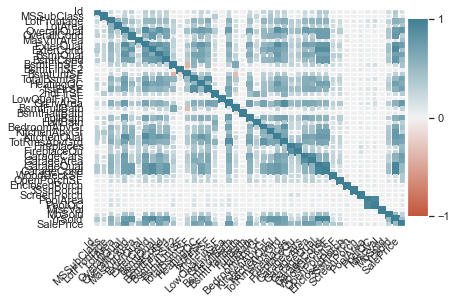

In [54]:
corrplot(data_numeric.corr(),size_scale=50, marker='s')

In [55]:
data_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold',
       'SalePrice'],
      dtype='object')

Se estandariza la información antes de pasarlo al modelo de PCA.

In [56]:
# standardization
scaler = StandardScaler()
norm_data = scaler.fit_transform(data_numeric)

In [65]:
df = pd.DataFrame(norm_data, index=data_numeric.index, columns=data_numeric.columns)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
0,-1.561951,0.170313,-0.081260,-0.163300,0.598193,-0.161159,0.515307,0.795851,0.105007,0.580892,0.252348,0.606596,-0.282827,-0.864546,-0.320953,0.795446,-0.549311,1.195682,-0.100352,0.425933,1.174024,-0.238167,0.788968,1.258649,0.292554,0.063091,0.632316,0.841332,-0.938711,-0.993897,0.312430,0.351881,0.263121,0.266204,-0.736754,0.257518,-0.336978,-0.116582,-0.270806,-0.068834,-0.066373,-0.081668,-1.328257,0.243296,0.382828
1,-1.559689,-0.787193,0.448139,-0.016566,0.080163,1.650638,-0.568090,-0.241967,0.105007,0.580892,0.252348,1.200558,-0.282827,-0.567365,0.507279,0.795446,0.328707,-0.767985,-0.100352,-0.302166,-0.797143,4.090518,0.788968,-0.754636,0.292554,0.063091,-0.337502,-0.086462,0.624732,0.661459,0.312430,-0.059296,0.263121,0.266204,1.665222,-0.693606,-0.336978,-0.116582,-0.270806,-0.068834,-0.066373,-0.081668,-0.327936,0.241124,0.075150
2,-1.557428,0.170313,0.024620,0.193964,0.598193,-0.161159,0.327371,0.795851,0.105007,0.580892,0.252348,0.126185,-0.282827,-0.234699,-0.190395,0.795446,-0.410904,1.223274,-0.100352,0.549449,1.174024,-0.238167,0.788968,1.258649,0.292554,0.063091,0.632316,-0.086462,0.624732,0.661459,0.312430,0.632229,0.263121,0.266204,-0.736754,-0.038734,-0.336978,-0.116582,-0.270806,-0.068834,-0.066373,-0.081668,1.005825,0.243296,0.553761
3,-1.555166,0.409689,-0.257726,-0.022946,0.598193,-0.161159,-0.568090,-0.241967,0.105007,-0.280962,1.435943,-0.463410,-0.282827,0.000384,-0.524952,0.043444,-0.322237,0.970343,-0.100352,0.437309,1.174024,-0.238167,-0.763345,-0.754636,0.292554,0.063091,0.632316,0.377435,0.624732,1.213245,1.648527,0.791092,0.263121,0.266204,-0.736754,-0.147879,4.264434,-0.116582,-0.270806,-0.068834,-0.066373,-0.081668,-1.328257,0.238953,-0.397763
4,-1.552905,0.170313,0.589312,0.578022,1.116224,-0.161159,1.366547,0.795851,0.105007,0.580892,0.252348,0.495228,-0.282827,-0.110504,0.268601,0.795446,0.075682,1.653257,-0.100352,1.219040,1.174024,-0.238167,0.788968,1.258649,1.286416,0.063091,0.632316,1.305229,0.624732,0.661459,1.648527,1.697550,0.263121,0.266204,0.810827,0.616138,-0.336978,-0.116582,-0.270806,-0.068834,-0.066373,-0.081668,2.006146,0.243296,0.855742


In [76]:
df.shape

(1454, 45)

In [77]:
df.dropna(inplace = True)

In [78]:
df.shape

(1446, 45)

In [79]:
np.any(np.isnan(df))

False

In [71]:
np.all(np.isfinite(df))

False

In [80]:
pca = PCA()
pca.fit(df)

PCA()

In [81]:
pca.explained_variance_ratio_

array([3.54630186e-01, 7.07907614e-02, 5.72338531e-02, 4.75746958e-02,
       3.97181815e-02, 3.41588776e-02, 2.73192509e-02, 2.46359800e-02,
       2.41661617e-02, 2.35244842e-02, 2.26864193e-02, 2.20928284e-02,
       2.15839960e-02, 2.04093392e-02, 1.92896356e-02, 1.81302679e-02,
       1.75742496e-02, 1.57791121e-02, 1.48404544e-02, 1.45041028e-02,
       1.36598631e-02, 1.28745854e-02, 1.16380293e-02, 8.70424408e-03,
       7.46909945e-03, 7.41131643e-03, 6.34361169e-03, 5.33962637e-03,
       4.74275802e-03, 4.30664604e-03, 3.91640799e-03, 3.12507952e-03,
       2.75760739e-03, 2.51089416e-03, 2.38179985e-03, 2.12501326e-03,
       2.03439641e-03, 1.90160994e-03, 1.82414365e-03, 1.52865089e-03,
       1.18283626e-03, 8.68306072e-04, 7.10637611e-04, 6.99384723e-32,
       2.91216420e-33])

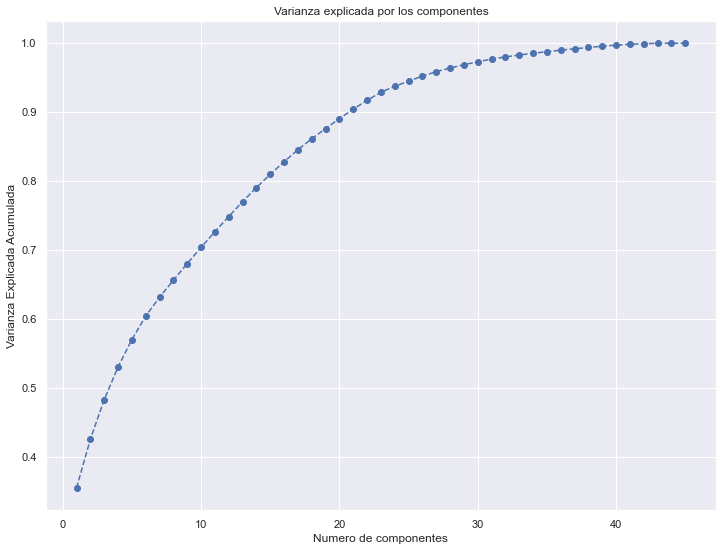

In [84]:
plt.figure(figsize=(12,9))
plt.plot(range(1,46), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--")
plt.title("Varianza explicada por los componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada Acumulada"); #Regla de oro es quedarnos con el 80% de la varianza

In [85]:
pca = PCA(n_components= 14)
pca.fit(df)

PCA(n_components=14)

In [103]:
indice = ['Componente '+ str(i) for i in range (1,15)]
posicion = [i for i in range (1,15)]
posicion

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [96]:
df_pca_comp = pd.DataFrame(data=pca.components_,
                           columns = df.columns.values,
                           index = indice
                           )

df_pca_comp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
Componente 1,-0.086922,-0.065219,-0.170535,-0.106111,-0.227353,-0.160668,-0.089077,-0.226252,-0.201726,-0.207603,-0.195887,-0.092622,-0.012787,-0.099675,-0.182388,-0.196188,-0.194127,-0.087847,-0.006542,-0.208394,-0.066784,-0.011142,-0.190389,-0.077478,-0.172823,-0.168276,-0.222246,-0.211797,-0.112437,-0.120986,-0.196616,-0.189276,-0.214026,-0.213592,-0.080676,-0.086596,-0.003280,-0.011037,-0.026673,-0.022586,-0.025450,-0.002988,-0.116618,-0.218013,-0.200352
Componente 2,-0.131370,-0.152182,0.058278,0.135771,0.048306,-0.264013,0.233829,-0.041495,-0.233771,0.018792,-0.150216,0.231328,-0.001548,-0.023569,0.193920,-0.081818,0.154655,0.039479,-0.009592,0.143519,0.145094,-0.034277,0.044805,0.072914,-0.111624,-0.237611,-0.034401,-0.000367,0.268065,0.261367,0.103873,0.129725,-0.206283,-0.209689,0.141231,0.143383,-0.095302,0.013749,0.065948,0.154468,0.165012,-0.027382,-0.131222,-0.234338,0.234846
Componente 3,0.045936,-0.186604,0.103260,0.105763,-0.041639,0.092597,-0.077174,0.008587,0.092342,0.032848,0.087552,0.338462,0.164970,-0.175711,0.208455,0.004384,0.183123,-0.474503,-0.042660,-0.200474,0.352921,0.036325,-0.171647,-0.340543,-0.167335,0.022648,0.021340,-0.177618,-0.059147,-0.099745,-0.038802,0.021290,0.083674,0.089836,0.033607,-0.093231,-0.007286,0.027171,-0.000930,0.066677,0.068812,0.010292,0.019616,0.077454,-0.047016
Componente 4,0.077761,0.081255,0.120419,0.117649,-0.084443,0.104162,-0.122604,-0.087306,0.071268,-0.115455,-0.007388,0.063282,0.119488,-0.231293,-0.114601,-0.105479,-0.062911,0.202465,0.159012,0.105925,0.038486,0.090430,-0.056563,0.100636,0.154236,0.067521,-0.069177,0.088906,0.038565,-0.038879,-0.134264,-0.102157,0.039418,0.035795,-0.011833,-0.025076,0.187753,-0.042214,0.063856,0.531191,0.535688,0.070470,-0.007453,0.037804,-0.081502
Componente 5,0.001734,-0.332369,0.178065,0.094961,-0.009699,-0.034534,-0.072269,-0.012933,-0.024921,-0.073040,-0.054095,-0.318577,-0.049037,0.521810,0.166347,-0.019634,0.192548,-0.195781,0.070638,0.010808,-0.364312,-0.008611,0.061016,-0.302419,0.071438,0.007936,-0.022772,0.037261,-0.047520,-0.007548,0.011428,0.035305,-0.036202,-0.036315,-0.109336,-0.018320,0.135258,0.059191,-0.038255,0.183489,0.191207,0.021289,0.002286,-0.019094,-0.022753
Componente 6,-0.029459,-0.240927,0.178501,0.285029,-0.087223,0.138700,-0.068732,-0.123896,0.054163,-0.152379,-0.012583,-0.054418,0.297169,-0.094942,-0.041092,-0.114590,0.054075,0.032911,0.017609,0.065018,-0.056151,0.188049,-0.105583,0.034062,0.164226,0.003403,-0.110390,0.104404,0.342585,0.283804,-0.131201,-0.131695,0.012584,0.007781,-0.024876,-0.068553,0.123902,0.023465,0.260668,-0.308632,-0.311082,0.091214,0.080179,0.020903,-0.033853
Componente 7,-0.038266,-0.189059,0.243970,0.303411,-0.097757,-0.079920,0.084353,-0.080120,-0.043833,-0.131466,-0.131063,0.093046,0.050624,-0.132366,-0.018295,-0.076371,0.040664,0.149473,-0.024256,0.134667,0.122197,-0.140557,0.089199,0.040630,0.224863,0.121045,-0.081227,0.173845,-0.372182,-0.395535,0.110014,0.163268,-0.050985,-0.054131,0.054677,0.010340,0.081080,0.054700,-0.339356,-0.161006,-0.136155,0.040131,-0.081251,-0.034138,0.021739
Componente 8,-0.154028,-0.017406,0.046802,0.003746,-0.009894,0.060512,0.128758,-0.006018,0.019954,0.010036,0.010458,0.046671,-0.079806,-0.055373,-0.033405,0.017741,-0.028220,0.000143,-0.114373,-0.028370,-0.213078,0.690957,0.006137,0.035704,0.010254,-0.028656,-0.004159,-0.029102,-0.054146,-0.027624,0.003656,-0.011099,0.010202,0.014904,0.247385,-0.139142,-0.227316,0.443682,-0.216937,0.048274,0.053230,-0.104246,0.052278,-0.002232

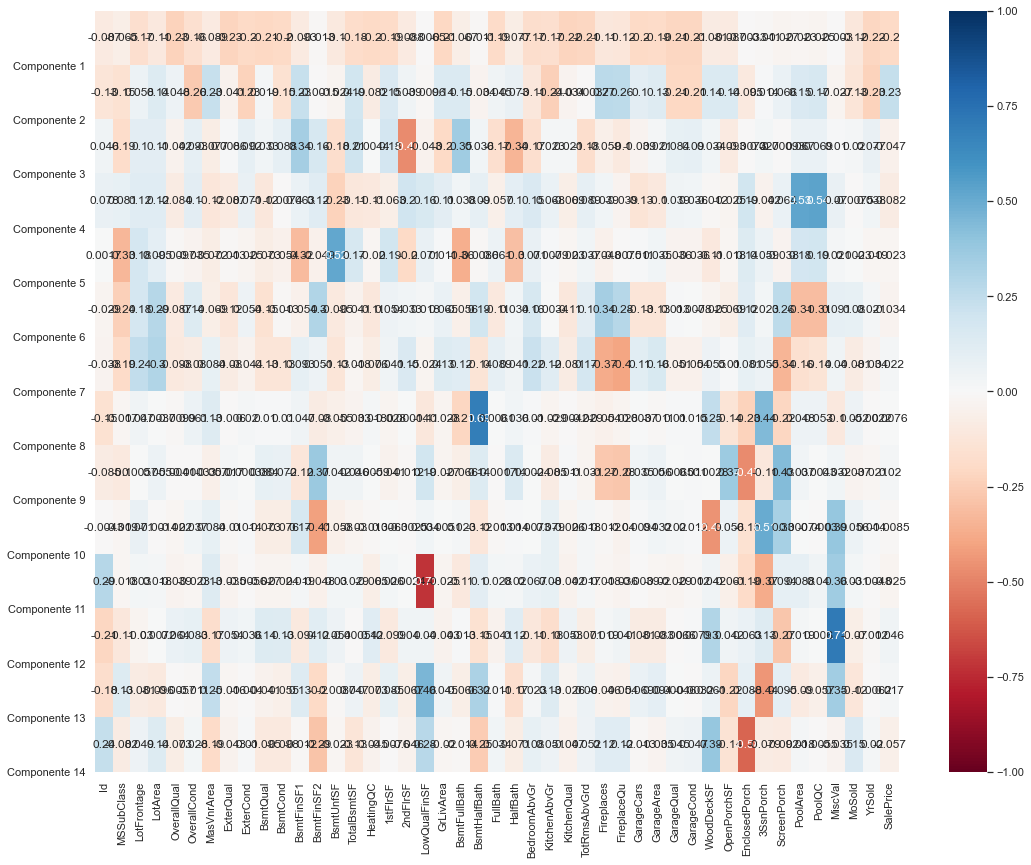

In [104]:
a4_dims = (18, 14)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap='RdBu',
            annot=True
            )
plt.yticks(posicion,
           indice
           );

In [122]:
caracteristicas = df_pca_comp.loc['Componente 2',:]>0

In [126]:
lista = caracteristicas[caracteristicas == True].index

In [127]:
lista 

Index(['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'FireplaceQu',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'SalePrice'],
      dtype='object')

Después de encontrar  en PCA una agrupación que tiene cierta relación con costo de venta se eligen esas varaibles para hacer una regresión de el precio de venta.

In [135]:
prediction_df = data_cle[lista]
prediction_df

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtQual,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,Fireplaces,FireplaceQu,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,PoolQC,SalePrice
0,65.0,8450,7,196.0,4,706,856,856,854,1710,1,2,1,0,0,2,548,0,61,0,0,0,0,208500
1,80.0,9600,6,0.0,4,978,1262,1262,0,1262,0,2,0,1,3,2,460,298,0,0,0,0,0,181500
2,68.0,11250,7,162.0,4,486,920,920,866,1786,1,2,1,1,3,2,608,0,42,0,0,0,0,223500
3,60.0,9550,7,0.0,3,216,756,961,756,1717,1,1,0,1,4,3,642,0,35,0,0,0,0,140000
4,84.0,14260,8,350.0,4,655,1145,1145,1053,2198,1,2,1,1,3,3,836,192,84,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,0.0,4,0,953,953,694,1647,0,2,1,1,3,2,460,0,40,0,0,0,0,175000
1456,85.0,13175,6,119.0,4,790,1542,2073,0,2073,1,2,0,2,3,2,500,349,0,0,0,0,0,210000
1457,66.0,9042,7,0.0,3,275,1152,1188,1152,2340,0,2,0,2,4,1,252,0,60,0,0,0,0,266500
1458,68.0,9717,5,0.0,3,49,1078,1078,0,1078,1,1,0,0,0,1,240,366,0,0,0,0,0,142125


In [155]:
np.any(np.isnan(prediction_df))

False

In [156]:
np.all(np.isfinite(prediction_df))

True

In [145]:
prediction_df.shape

(1446, 24)

In [148]:
prediction_df.dropna(inplace = True)


In [149]:
prediction_df.shape

(1446, 24)

In [150]:
prediction_df.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'FireplaceQu',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'SalePrice'],
      dtype='object')

,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtQual,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,Fireplaces,FireplaceQu,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,PoolQC
0,65.0,8450,7,196.0,4,706,856,856,854,1710,1,2,1,0,0,2,548,0,61,0,0,0,0
1,80.0,9600,6,0.0,4,978,1262,1262,0,1262,0,2,0,1,3,2,460,298,0,0,0,0,0
2,68.0,11250,7,162.0,4,486,920,920,866,1786,1,2,1,1,3,2,608,0,42,0,0,0,0
3,60.0,9550,7,0.0,3,216,756,961,756,1717,1,1,0,1,4,3,642,0,35,0,0,0,0
4,84.0,14260,8,350.0,4,655,1145,1145,1053,2198,1,2,1,1,3,3,836,192,84,0,0,0,0


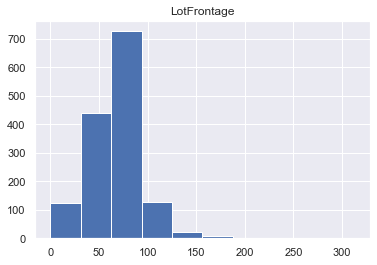

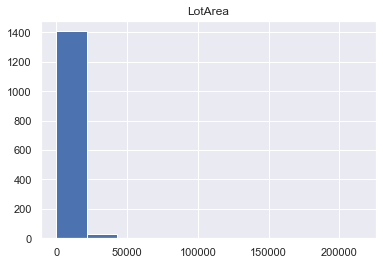

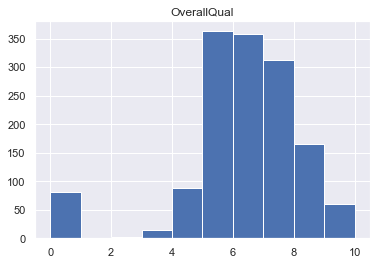

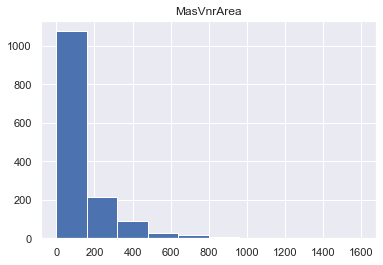

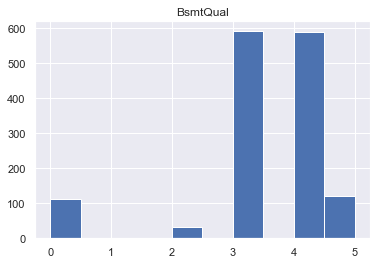

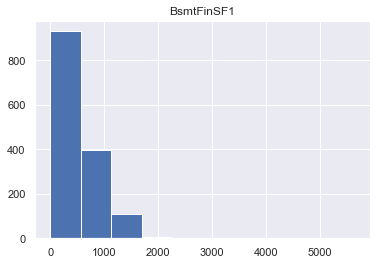

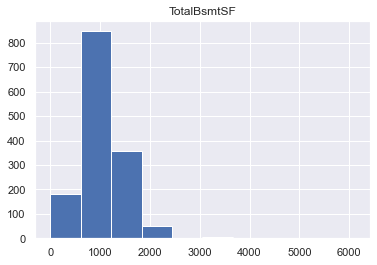

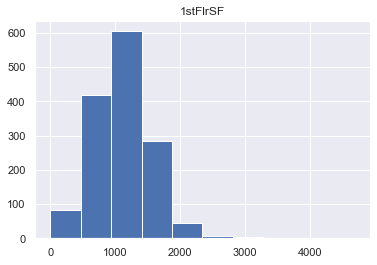

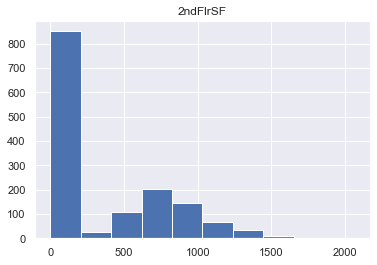

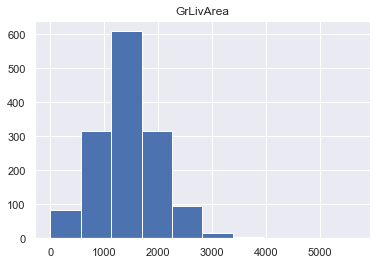

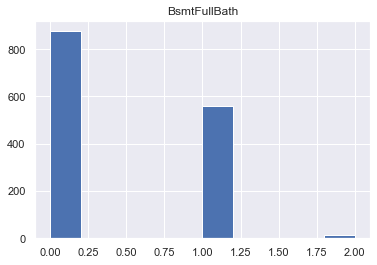

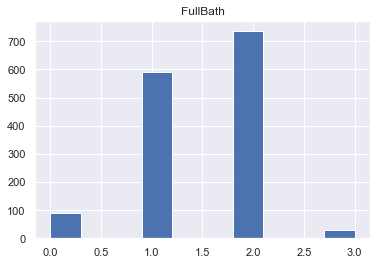

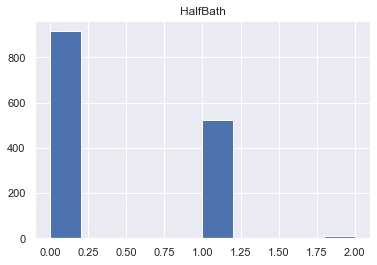

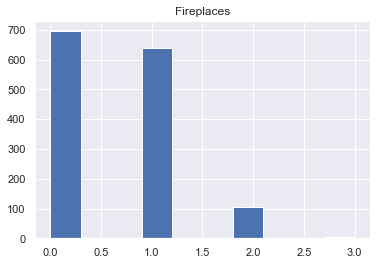

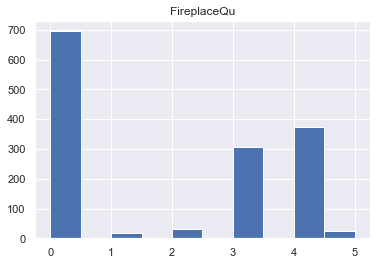

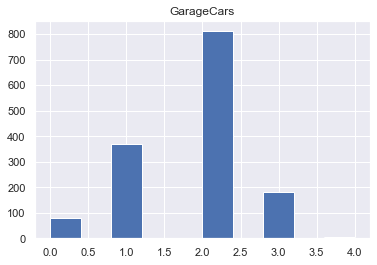

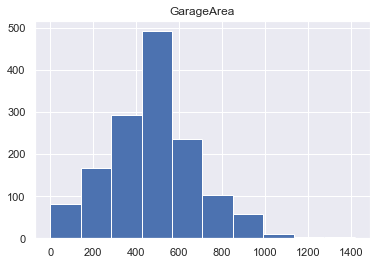

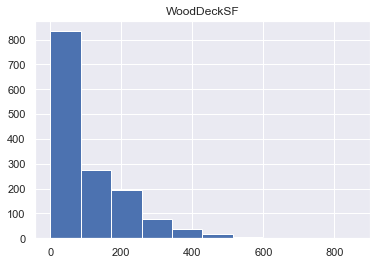

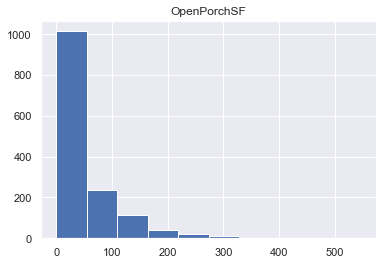

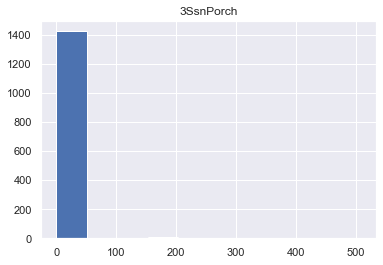

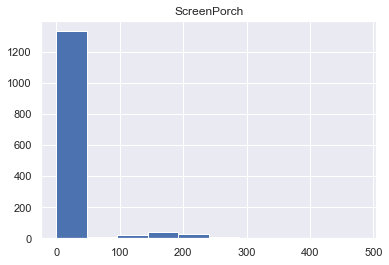

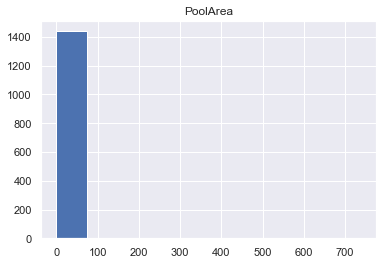

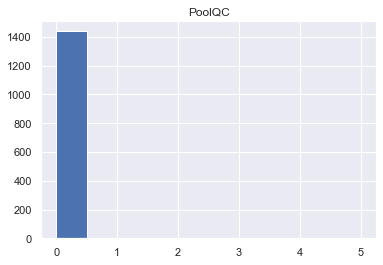

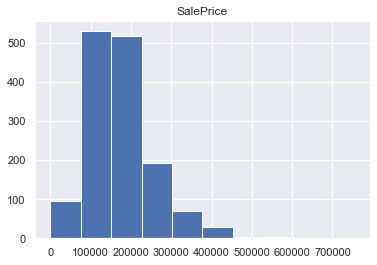

In [161]:
for column in prediction_df.columns :
    prediction_df[column].hist()
    plt.title(column)
    plt.show()

In [165]:
prediction_df.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'MasVnrArea', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'FireplaceQu',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch',
       'PoolArea', 'SalePrice'],
      dtype='object')

In [164]:
prediction_df.drop(['PoolQC', '3SsnPorch'], axis = 1,inplace = True)

TypeError: '(slice(None, None, None), slice(None, None, None))' is an invalid key

In [166]:
y = prediccion_df['SalePrice']
x = prediccion_df.drop('SalePrice',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.2)

In [167]:
linreg2 = LinearRegression()
linreg2.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').